In [2]:
# imports 
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [3]:
join_cols = ['שם ישוב', 'מספר קלפי']
drop_cols =  ['סמל ישוב', 'בזב', 'מצביעים', 'פסולים']
total_col = 'כשרים'

def read_and_processes(file, suffix):
     # read the file
    df = pandas.read_csv(file, encoding = 'windows-1255')
    
    # basic processing 
    df.columns = df.columns.map(lambda col: col.strip()) # strip whitespaces in columns
    df = df.drop(drop_cols, axis=1) # remove unnecessary columns
    df = df[(df[total_col] > 0)] # removing ballot with n  valid votes 
    
    # norming to percentage (% of valid votes)
    total_col_idx = df.columns.get_loc(total_col)
    df = df.apply(lambda row: [row[idx]/row[total_col_idx] if idx > total_col_idx else row[idx] for idx in range(len(row))], axis=1) 
    df = df.drop([total_col], axis=1)
    
    # applying suffix
    df.columns = df.columns.map(lambda x: x if x in join_cols else str(x) + suffix) 
    return df

In [4]:
# reading knesset 20 votes from https://www.votes20-media.gov.il/files/expb.csv
k20 = read_and_processes('knesset20.csv', '_20')
print ('Knesset 20: number of ballot boxes =', len(k20))

# reading knesset 21 votes from https://media21.bechirot.gov.il/files/expb.csv
k21 = read_and_processes('knesset21.csv', '_21')
print ('Knesset 21: number of ballot boxes =', len(k21))

Knesset 20: number of ballot boxes = 10412
Knesset 21: number of ballot boxes = 10765


In [5]:
k20_21_merged = pandas.merge(k20, k21, left_on=join_cols, right_on=join_cols)
print ('Knesset 20/21: number of matched ballot boxes =', len(k20_21_merged))

k20_features = [col for col in k20_21_merged.columns if col.endswith('_20')]
k20_len = len(k20_features)

k21_features = [col for col in k20_21_merged.columns if col.endswith('_21')]
k21_len = len(k21_features)

print ('Knesset 20: number of parties =', k20_len)
print ('Knesset 21: number of parties =', k21_len)

k20_data = k20_21_merged[k20_features]
k21_data = k20_21_merged[k21_features]

Knesset 20/21: number of matched ballot boxes = 8565
Knesset 20: number of parties = 26
Knesset 21: number of parties = 43


In [6]:
# modeling 
numpy.random.seed(9876) # for reproducibility

# hidden dims = mean of input and output layers 
hidden_dims = int((k20_len + k21_len)/2) 
model = Sequential()

model.add(Dense(input_dim=k20_len, units=hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=k21_len, activation='relu'))

model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
model.fit(k20_data, k21_data, epochs=100, validation_split=0.8)

Train on 1712 samples, validate on 6853 samples
Epoch 1/100
1712/1712 [==============================] - 1s 477us/step - loss: 0.0044 - acc: 0.5590 - val_loss: 0.0025 - val_acc: 0.5217
Epoch 2/100
1712/1712 [==============================] - 0s 127us/step - loss: 0.0026 - acc: 0.7634 - val_loss: 0.0017 - val_acc: 0.6714
Epoch 3/100
1712/1712 [==============================] - 0s 130us/step - loss: 0.0021 - acc: 0.7956 - val_loss: 0.0012 - val_acc: 0.8071
Epoch 4/100
1712/1712 [==============================] - 0s 111us/step - loss: 0.0018 - acc: 0.8201 - val_loss: 0.0010 - val_acc: 0.8242
Epoch 5/100
1712/1712 [==============================] - 0s 122us/step - loss: 0.0016 - acc: 0.8359 - val_loss: 9.0607e-04 - val_acc: 0.8275
Epoch 6/100
1712/1712 [==============================] - 0s 129us/step - loss: 0.0015 - acc: 0.8324 - val_loss: 8.7646e-04 - val_acc: 0.8223
Epoch 7/100
1712/1712 [==============================] - 0s 135us/step - loss: 0.0014 - acc: 0.8306 - val_loss: 8.3975e-04

1712/1712 [==============================] - 0s 112us/step - loss: 7.7988e-04 - acc: 0.8814 - val_loss: 6.9124e-04 - val_acc: 0.8484
Epoch 58/100
1712/1712 [==============================] - 0s 93us/step - loss: 7.9196e-04 - acc: 0.8820 - val_loss: 7.2088e-04 - val_acc: 0.8491
Epoch 59/100
1712/1712 [==============================] - 0s 118us/step - loss: 7.8514e-04 - acc: 0.8832 - val_loss: 6.7593e-04 - val_acc: 0.8563
Epoch 60/100
1712/1712 [==============================] - 0s 120us/step - loss: 7.5490e-04 - acc: 0.8908 - val_loss: 7.0229e-04 - val_acc: 0.8456
Epoch 61/100
1712/1712 [==============================] - 0s 128us/step - loss: 7.4445e-04 - acc: 0.8884 - val_loss: 6.9792e-04 - val_acc: 0.8458
Epoch 62/100
1712/1712 [==============================] - 0s 142us/step - loss: 7.5927e-04 - acc: 0.8879 - val_loss: 6.8547e-04 - val_acc: 0.8491
Epoch 63/100
1712/1712 [==============================] - 0s 141us/step - loss: 7.8119e-04 - acc: 0.8814 - val_loss: 7.1699e-04 - val_acc:

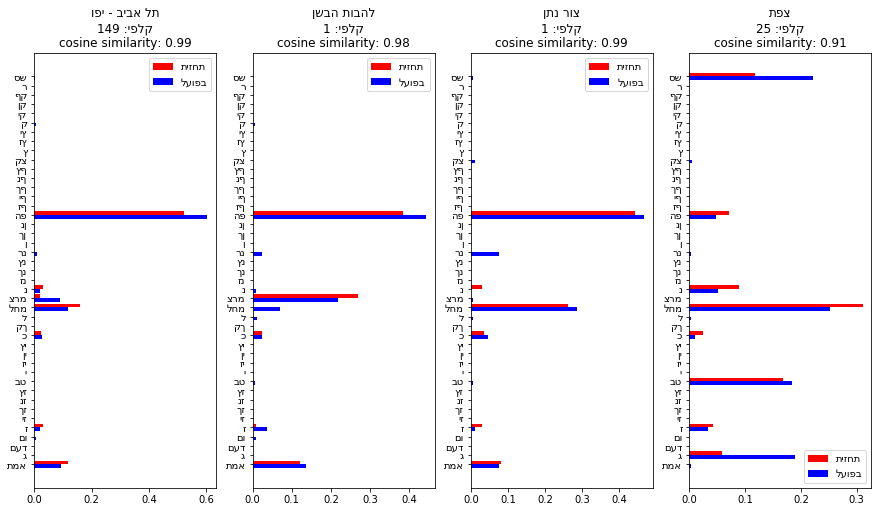

In [7]:
# predicting    
# k21_predict = pandas.DataFrame(model.predict(k20_data), columns = k21_features)
k21_predict = model.predict(k20_data)

features_name_20 = [f.replace('_20', '')[::-1] for f in k20_features]
features_name_21 = [f.replace('_21', '')[::-1] for f in k21_features]

ind = numpy.arange(len(features_name_21))
width = 0.4


def plot_me(pos, n):
    plt.subplot(pos)
    plt.barh(ind+width/2, k21_predict[n], width, color='red', label='תיזחת')
    plt.barh(ind-width/2, k21_data.values[n], width, color='blue', label='לעופב')
    plt.yticks(ind, features_name_21)

    location = str(k20_21_merged['שם ישוב'][n])[::-1] 
    ballot = str(int(k20_21_merged['מספר קלפי'][n])) + ' :יפלק'
    accuracy = str(round(cosine_similarity([k21_predict[n]], [k21_data.values[n]])[0][0], 2))
    plt.title( location + '\n' + ballot + '\n' + 'cosine similarity: ' + accuracy)
    plt.legend()

plt.figure(figsize=(15,8))
plot_me(141, numpy.random.randint(0, len(k20_21_merged)))
plot_me(142, numpy.random.randint(0, len(k20_21_merged)))
plot_me(143, numpy.random.randint(0, len(k20_21_merged)))
plot_me(144, numpy.random.randint(0, len(k20_21_merged)))

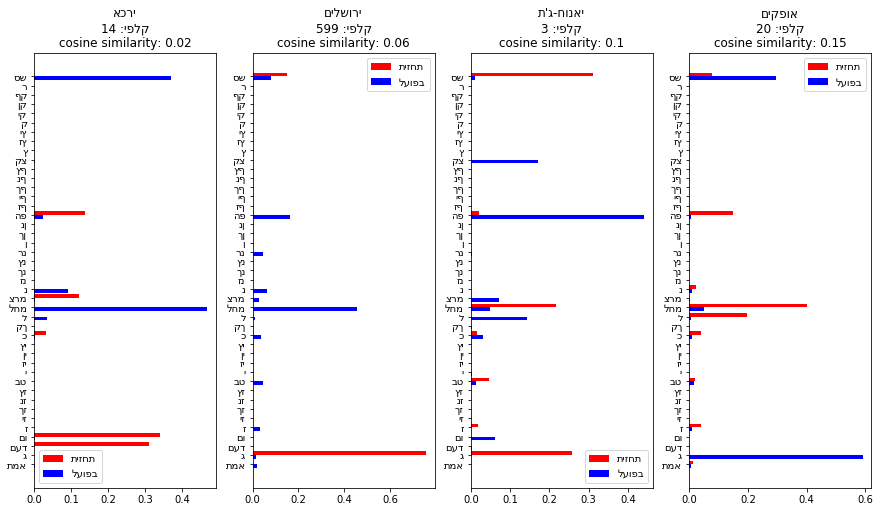

In [8]:
# find anomalies
similarities = [cosine_similarity([k21_data.values[idx]], [k21_predict[idx]])[0][0] for idx in range(len(k20_21_merged))] 
worse = (numpy.array(similarities)).argsort()[:4]
plt.figure(figsize=(15,8))
plot_me(141, worse[0])
plot_me(142, worse[1])
plot_me(143, worse[2])
plot_me(144, worse[3])

In [15]:
def remove_zeros(df, axis):
    zero_idx = numpy.argwhere(df.sum(axis=1-axis).values == 0).flatten()
    labels = df.columns[zero_idx] if axis == 1 else df.index[zero_idx]
    return df.drop(labels, axis=axis)


diag = numpy.diagflat(numpy.ones(k20_len))
diag_df = pandas.DataFrame(diag, columns=[c[::-1] for c in features_name_20])
diag_df

,אמת,ג,ודעם,ז,זך,זץ,טב,י,יז,יך,...,ני,נץ,ע,פה,ף,ףץ,קנ,קץ,רק,שס
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


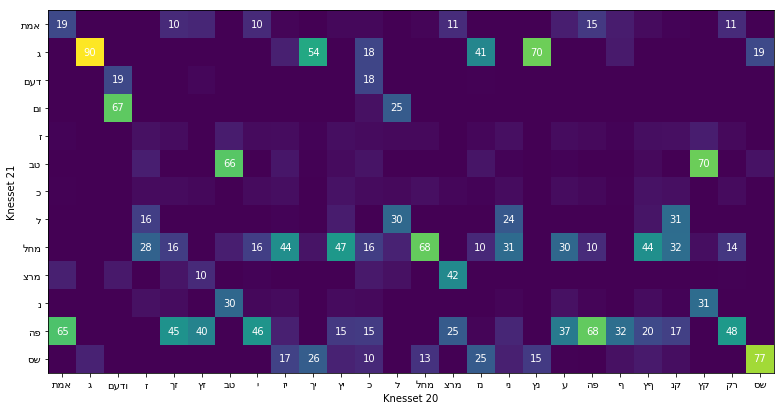

In [20]:


diag_predict = pandas.DataFrame(model.predict(diag), columns=features_name_21, index=features_name_20)
diag_predict = remove_zeros(diag_predict, axis=0)
diag_predict = remove_zeros(diag_predict, axis=1)

plt.figure(figsize=(13, 13))
plt.imshow(diag_predict.T)
plt.xticks(numpy.arange(len(diag_predict.T.columns)), diag_predict.T.columns)
plt.ylabel("Knesset 21")

plt.yticks(numpy.arange(len(diag_predict.T.index)), diag_predict.T.index)
plt.xlabel("Knesset 20")

# Loop over data dimensions and create text annotations.
for i in range(len(diag_predict.T.index)):
    for j in range(len(diag_predict.T.columns)):
        v = diag_predict.T.values[i, j]*100
        if v > 10:
            text = plt.text(j, i, int(v), ha="center", va="center", color="w")

plt.show()

אמת -> פה 0.97
ג -> שס 0.53
דעם -> ום 0.99
ום -> דעם 0.99
ז -> נ 0.78
טב -> נ 0.98
כ -> מחל 0.89
ל -> כ 0.5
מחל -> כ 0.89
מרצ -> אמת 0.55
נ -> טב 0.98
פה -> אמת 0.97
שס -> ג 0.53


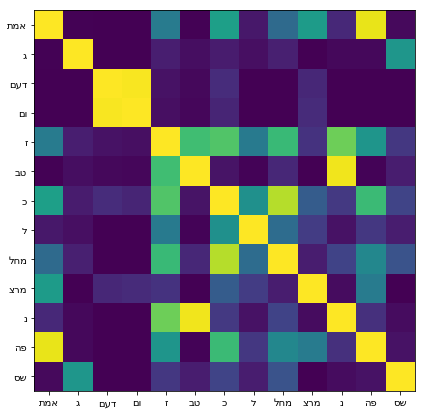

In [53]:
dist = numpy.zeros((len(diag_predict.columns), len(diag_predict.columns)))

for i in range(len(dist)):
    max_similarity = 0
    most_similar = 0
    for j in range(len(dist)):
        ii = diag_predict[diag_predict.columns[i]]
        jj = diag_predict[diag_predict.columns[j]]
        dist[i,j] = cosine_similarity([ii], [jj])
        
        if dist[i, j] > max_similarity and i != j:
            max_similarity = dist[i, j]
            most_similar = j

    if max_similarity > 0:
        print (diag_predict.columns[i][::-1], '->', diag_predict.columns[most_similar][::-1], round(max_similarity, 2))

dist = pandas.DataFrame(dist, columns=diag_predict.columns, index=diag_predict.columns)
dist = remove_zeros(dist, 0)
dist = remove_zeros(dist, 1)

plt.figure(figsize=(7, 7))
plt.imshow(dist)
plt.xticks(numpy.arange(len(dist.columns)), dist.columns)
plt.yticks(numpy.arange(len(dist.columns)), dist.columns)
plt.show()

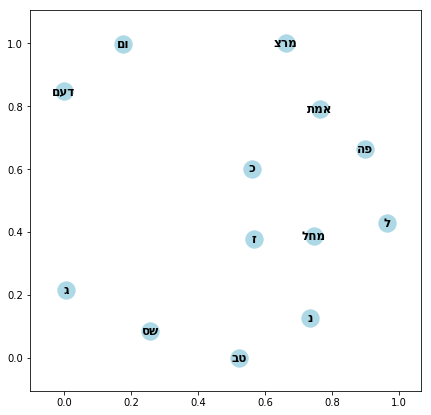

In [66]:
import networkx as nx
G = nx.Graph()

for i in range(len(dist.columns)):
    for j in range(i, len(dist.columns)):
        G.add_edge(dist.columns[i], dist.columns[j], {'weight': dist.values[i, j]})
        
plt.figure(figsize=(7, 7))
nx.draw_networkx(G, with_labels=True, node_color='lightblue', edge_color='white', font_weight='bold')

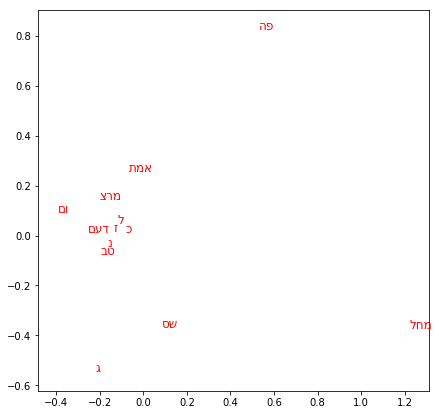

In [30]:
# dist
# projected = IncrementalPCA(n_components=2).fit_transform(diag_predict.T)
# projected.shape

# # projected = TSNE(n_components=2).fit_transform(dist)
# projected = pandas.DataFrame(projected, columns=['x', 'y'])
# projected['party'] = pandas.Series(diag_predict.T.index)

# plt.figure(figsize=(7, 7))
# plt.scatter(projected['x'], projected['y'], color='w')

# # # Loop over data dimensions and create text annotations.
# for i in range(len(diag_predict.T.index)):
#     rec = projected.loc[i]
#     text = plt.text(rec['x'], rec['y'], rec['party'], color='red', fontsize=12)


# plt.show()